# Project

### Package Imports

In [2]:
import os
import re
import copy
import time
from time import gmtime, strftime
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml import regression, evaluation, Pipeline, classification, clustering, feature
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
import pandas as pd
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

## Data Preprocessing

In [3]:
df = spark.read.csv("./US_Listings.csv", inferSchema=True, header=True)

In [4]:
print(df.count())
df = df.filter(df["ZipName"].isNotNull()).filter(df["DaysonMarket"].isNotNull()).filter(df["Month"].isNotNull())
print(df.count())
print(df.printSchema())
df = df.withColumn("State",fn.regexp_extract(fn.col('ZipName'), '(.)(,)(\s+)(\w+)', 4))\
.withColumn("City",fn.regexp_extract(fn.col('ZipName'), '(\w+)(,)(\s+)(\w+)', 1))\
.withColumn("Year",fn.regexp_extract(fn.col('Month'), '(\w+)(/)(\w+)(/)(\w+)', 5))

974067
974035
root
 |-- Month: string (nullable = true)
 |-- ZipCode: integer (nullable = true)
 |-- ZipName: string (nullable = true)
 |-- Footnote: string (nullable = true)
 |-- MedianListingPrice: integer (nullable = true)
 |-- MedianListingPriceMUponM: double (nullable = true)
 |-- MedianListingPriceYUponY: double (nullable = true)
 |-- ActiveListingCount: integer (nullable = true)
 |-- ActiveListingCountMUponM: double (nullable = true)
 |-- ActiveListingCountYUponY: double (nullable = true)
 |-- DaysonMarket: integer (nullable = true)
 |-- DaysonMarketMUponM: double (nullable = true)
 |-- DaysonMarketYUponY: double (nullable = true)
 |-- NewListingCount: integer (nullable = true)
 |-- NewListingCountMUponM: double (nullable = true)
 |-- NewListingCountYUponY: double (nullable = true)
 |-- PriceIncreaseCount: integer (nullable = true)
 |-- PriceIncreaseCountMUponM: double (nullable = true)
 |-- PriceIncreaseCountYUponY: double (nullable = true)
 |-- PriceDecreaseCount: integer (nul

## Descriptive statistics

+-----+----------+------------------+
|State|Properties|Avg Days On Market|
+-----+----------+------------------+
|   VT|      7670|165.50352020860495|
|   ME|     15635|159.83108410617206|
|   MT|      5850|140.55008547008546|
|   WY|      2405|121.42494802494802|
|   DE|      3224|120.92307692307692|
|   NM|      5265|119.80094966761634|
|   NC|     32661|118.88077523652062|
|   ID|      7475|118.50367892976588|
|   MS|      7995|116.99712320200125|
|   SC|     14113|115.20229575568625|
|   AL|     19345| 114.6770224864306|
|   WV|      6668|113.68881223755248|
|   AR|     10462|113.30443509845153|
|   WI|     28971|112.95429912671293|
|   NH|     10985|112.76167501137915|
|   NY|     61544| 107.3183088522033|
|   HI|      3545|104.24851904090268|
|   VA|     29569|103.52561804592648|
|   PA|     47385| 99.84271393901024|
|   AK|      2104| 98.68773764258555|
|   TN|     22884| 98.51830973606013|
|   OR|     12515|  98.1437475029964|
|   KY|     12709| 97.51373042725628|
|   CT|     

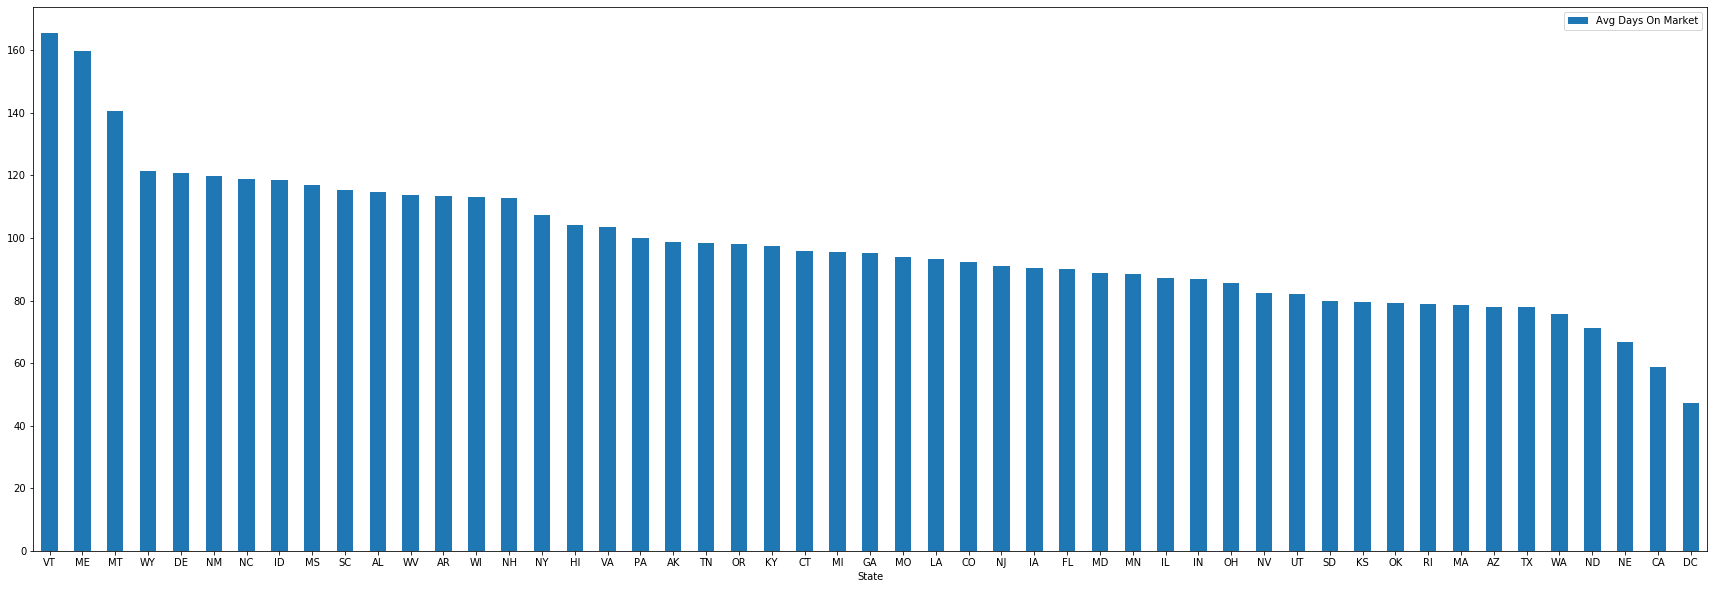

In [4]:
df.createOrReplaceTempView("dataframe")
sqlDF = spark.sql("""SELECT State, COUNT(City) as Properties, AVG(`DaysonMarket`) as `Avg Days On Market` FROM dataframe group by State order by AVG(`DaysonMarket`) DESC""")
sqlDF.show(sqlDF.count())
pandasDf = sqlDF.toPandas()
pandasDf.plot.bar(x='State', y='Avg Days On Market', figsize = (30,10), xlim = (0,170), rot=0)

+----+----------+--------------------+
|Year|Properties|avg(AvgListingPrice)|
+----+----------+--------------------+
|2017|    135274|  405276.39457693277|
|2016|    180394|  384687.89372152067|
|2015|    180037|  364707.79950787895|
|2014|    179155|   341040.7356758115|
|2013|    179247|    324934.495974828|
|2012|    119928|  309997.54269228206|
+----+----------+--------------------+

6


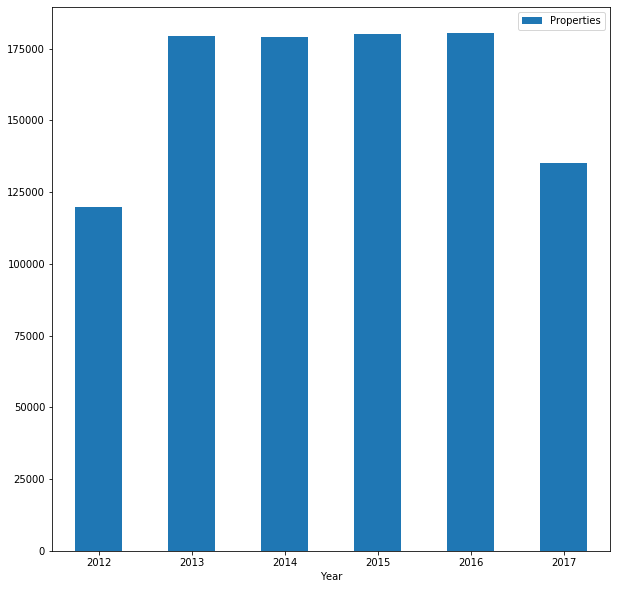

In [5]:
sqlDF2 = spark.sql("""SELECT Year, COUNT(City) AS Properties, AVG(`AvgListingPrice`) FROM dataframe group by Year order by AVG(`AvgListingPrice`) DESC""")
sqlDF2.show(sqlDF2.count())
usdf2 = sqlDF2.toPandas()
print(len(usdf2))
propnum = usdf2.sort_values(by=['Year'], ascending = True)
propnum.plot.bar(x='Year', y='Properties', figsize = (10,10), rot=0)

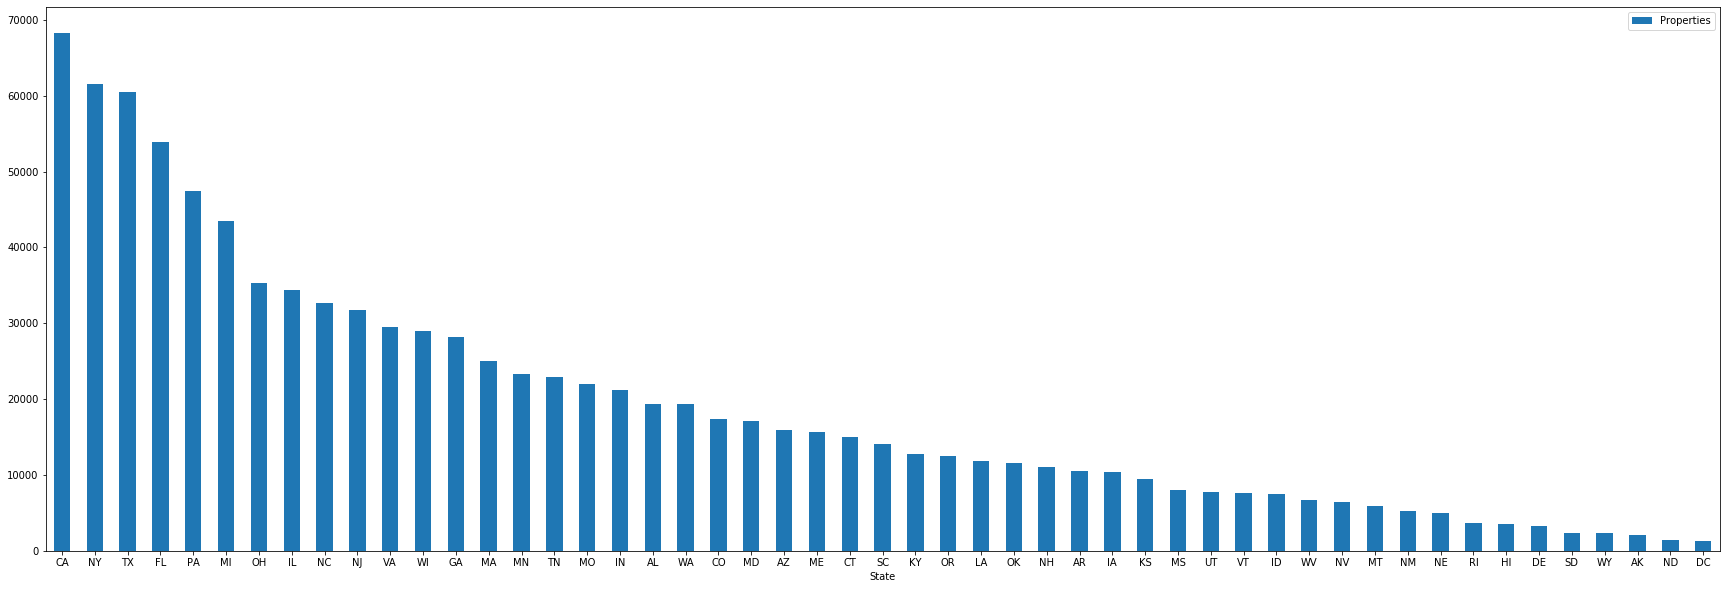

In [6]:
#number of properties sold between 5/1/2012 and 9/1/2017 by States.
propnum = pandasDf.sort_values(by=['Properties'], ascending = False)
propnum.plot.bar(x='State', y='Properties', figsize = (30,10), rot=0)

+-----+----------+--------------------+
|State|Properties|StateAvgListingPrice|
+-----+----------+--------------------+
|   NV|       289|  3007244.6366782007|
|   WY|       132|   2929525.757575758|
|   NY|      6131|   2341260.968846844|
|   KY|         2|           2316450.0|
|   IA|         1|           2152800.0|
|   CA|     12179|  2085553.9453157075|
|   CT|      1663|   1806447.624774504|
|   HI|      1226|  1798635.9706362153|
|   GA|       251|  1763983.6653386455|
|   NE|         1|           1739000.0|
|   CO|      1594|  1716382.4968632371|
|   NJ|      2357|   1677995.672464998|
|   MA|      3236|  1667793.0778739185|
|   FL|      2848|  1596566.1165730336|
|   DC|       256|      1547083.203125|
|   AZ|       335|  1505191.9402985075|
|   WA|       874|  1500794.0503432495|
|   UT|       306|  1497515.0326797385|
|   VA|       723|  1447684.9239280776|
|   RI|       232|  1416965.0862068965|
|   TX|      1279|  1410123.4558248632|
|   MD|       468|   1400869.017094017|


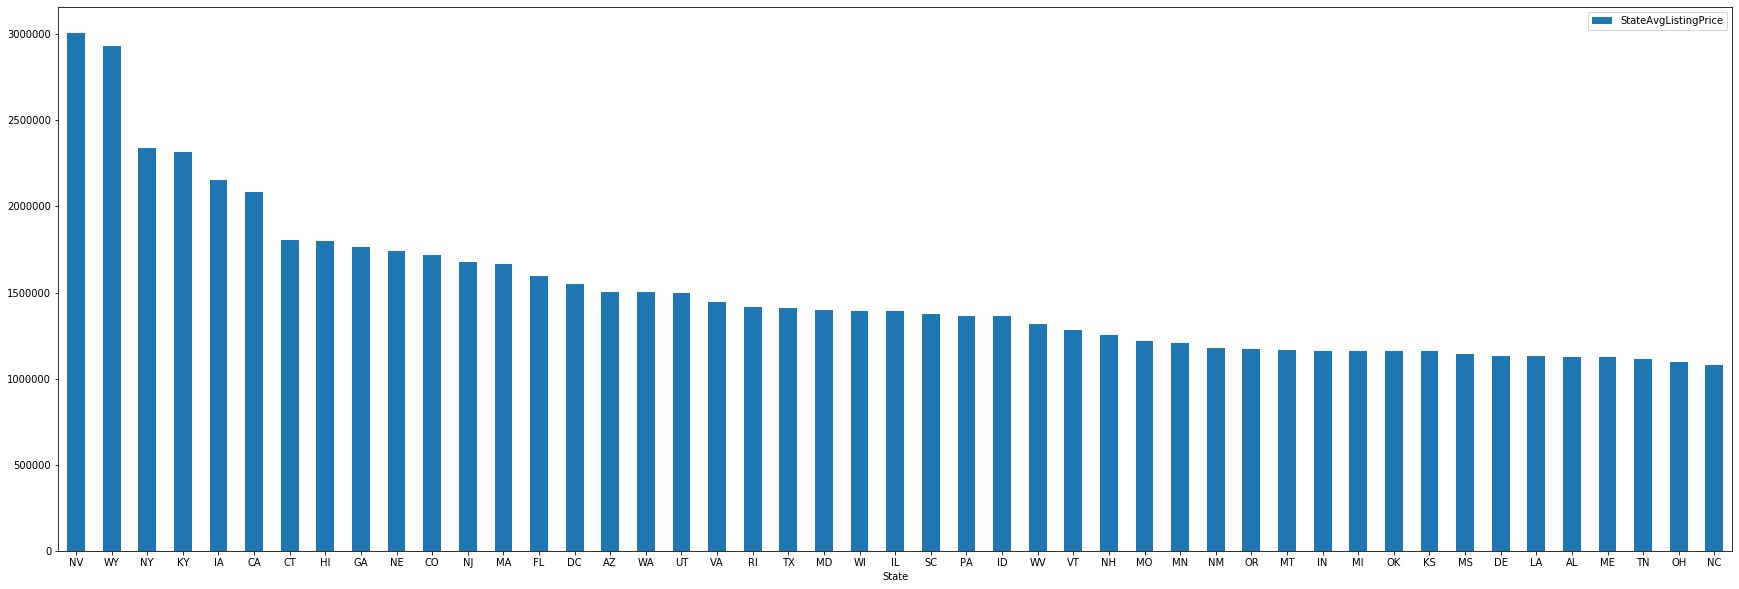

In [7]:
sqlDF = spark.sql("""SELECT State, COUNT(City) as Properties, AVG(`AvgListingPrice`) as `StateAvgListingPrice` FROM dataframe where AvgListingPrice > 1000000 group by State order by AVG(`AvgListingPrice`) DESC""")
sqlDF.show(sqlDF.count())
sqlDF.toPandas().plot.bar(x='State', y='StateAvgListingPrice', figsize = (30,10), xlim = (0,170), rot=0)

+----+---------------+
|Year|AvgListingPrice|
+----+---------------+
|2017|         248200|
|2017|         444400|
|2017|         250900|
|2017|         331500|
|2017|         257300|
|2017|         301000|
|2017|         187100|
|2017|         208500|
|2017|         133800|
|2017|         306100|
|2017|         368400|
|2017|         287100|
|2017|         361300|
|2017|         484400|
|2017|         620100|
|2017|         389100|
|2017|         216900|
|2017|         234100|
|2017|         291200|
|2017|         252000|
|2017|         425000|
|2017|         406800|
|2017|         199200|
|2017|         444500|
|2017|         290300|
|2017|         375800|
|2017|         238900|
|2017|         293500|
|2017|         276700|
|2017|         340600|
|2017|         380300|
|2017|         145300|
|2017|         421400|
|2017|         161200|
|2017|         136400|
|2017|         173700|
|2017|         164900|
|2017|         172300|
|2017|         138800|
|2017|         268800|
|2017|     

(0, 1000000)

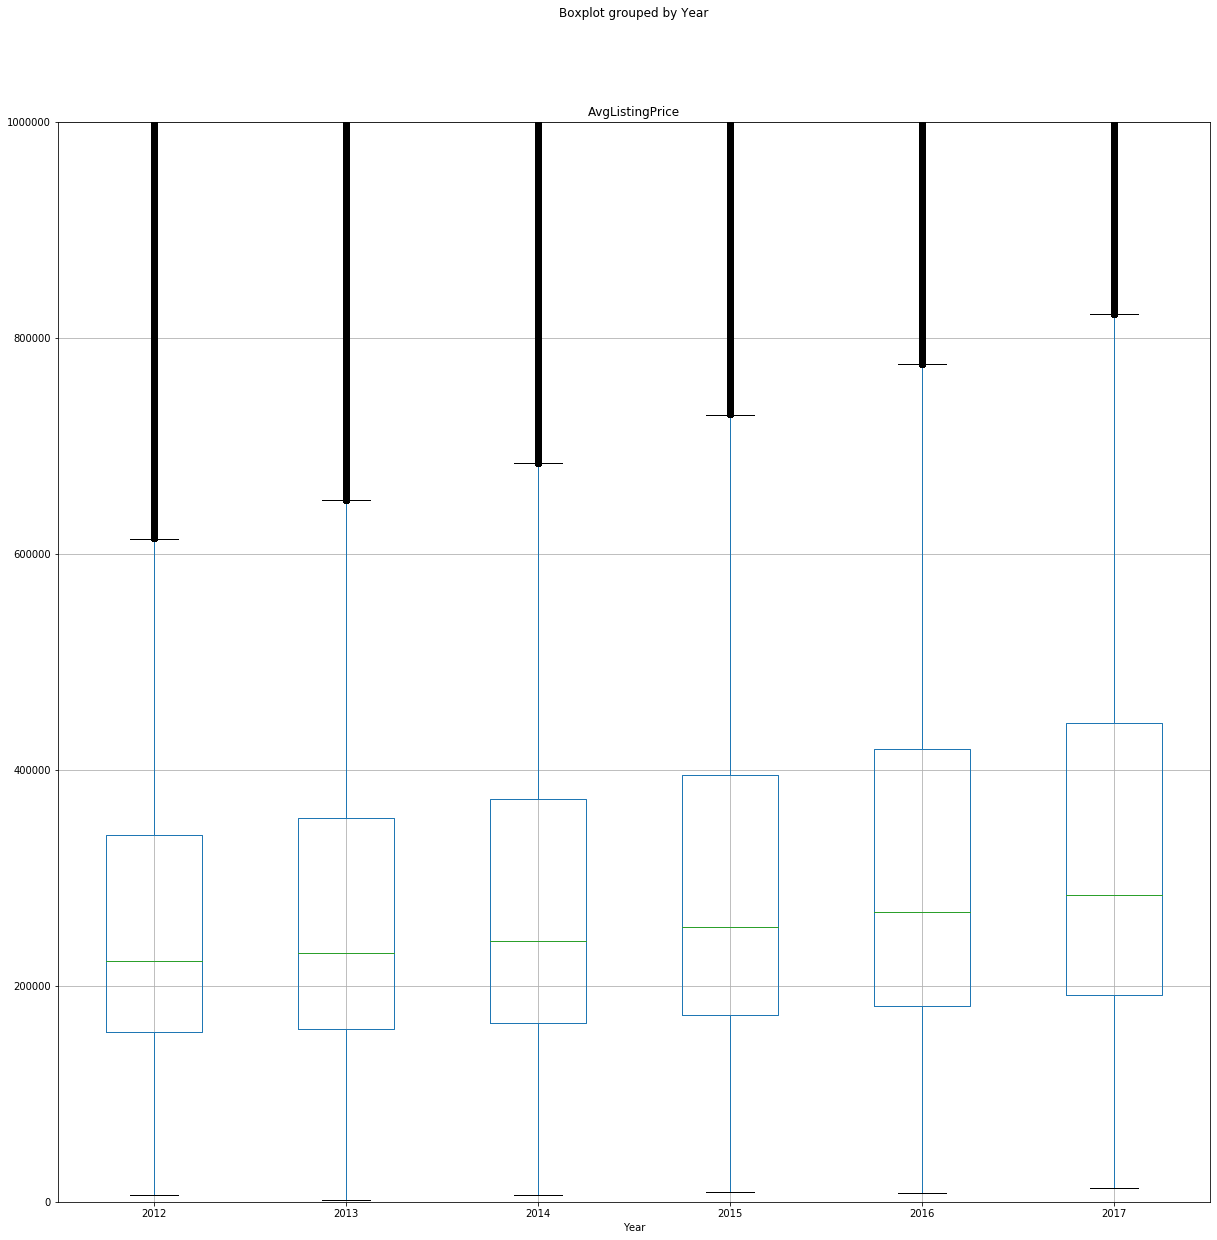

In [8]:
#Box plot dataframe
sqlDF3 = spark.sql("""SELECT Year, AvgListingPrice FROM dataframe ORDER BY Year DESC""")
sqlDF3.show(sqlDF.count())
usdf3 = sqlDF3.toPandas()
print(len(usdf3))
priceyear = usdf3.sort_values(by=['Year'], ascending = True)
priceyear.boxplot(column=['AvgListingPrice'], by = 'Year', figsize=(20,20)).set_ylim(0,1000000)

# Unsupervised Learning using K-Means:

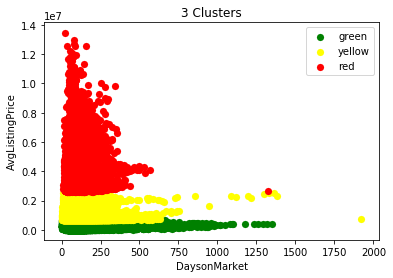

In [9]:
def kmeans(num_clusters):
    k_means_pipe = Pipeline(stages = [ 
    feature.VectorAssembler(inputCols=["DaysonMarket", "AvgListingPrice"],outputCol="scores"),
    #feature.VectorAssembler(inputCols=["PriceDecreaseCount", "PriceIncreaseCount", "DaysonMarket", "AvgListingPrice", "NewListingCount", "ActiveListingCount", "TotalListingCount"],outputCol="features"),
    #feature.PCA(k=2, inputCol="features", outputCol="scores"),
    clustering.KMeans(k = num_clusters, seed = 2, featuresCol='scores', predictionCol='kmeans_clust')]).fit(df)
    kmeansModel = k_means_pipe.transform(df)
    colmap = {0: 'green', 1: 'yellow', 2: 'red',3: 'purple', 4: 'blue', 5: 'brown',6: 'teal', 7: 'magenta'}
    colors = []
    X = np.array(kmeansModel.select('scores').rdd.map(lambda x: x['scores']).collect())
    for _ in np.array(kmeansModel.select('kmeans_clust').rdd.map(lambda x: x['kmeans_clust']).collect()):
        colors.append(colmap[_])
    fig, ax = plt.subplots()
    #plt.figure(figsize=(30,15))
    for i in range(num_clusters):
        tempX,tempY=[],[]
        for j,_ in enumerate(colors):
            if _==colmap[i]:
                tempX.append(X[j,0])
                tempY.append(X[j,1])
        plt.scatter(tempX, tempY, s=50, label= colmap[i], linewidth=0.1, c= colmap[i])
    plt.title(str(num_clusters)+" Clusters")
    plt.xlabel("DaysonMarket")
    plt.ylabel("AvgListingPrice")
    plt.legend()
    plt.savefig("kmeans.png")
    return kmeansModel
kmeansModel = kmeans(3)

## Random forest
### Predict kmeans

In [11]:
va = feature.VectorAssembler(inputCols=["PriceDecreaseCount", "PriceIncreaseCount", "DaysonMarket", "NewListingCount", "ActiveListingCount", "TotalListingCount"],outputCol="features")
training_df, testing_df, validation_df = va.transform(kmeansModel).randomSplit([0.6, 0.3, 0.1],seed =1)
rf = classification.RandomForestClassifier(featuresCol="features", labelCol='kmeans_clust')
rfModel = rf.fit(training_df)

In [12]:
bce = evaluation.BinaryClassificationEvaluator(labelCol='kmeans_clust')
print('Training Data Accuracy: ',bce.evaluate(rfModel.transform(testing_df)))

print('Validation Data Accuracy: ',bce.evaluate(rfModel.transform(validation_df)))

Training Data Accuracy:  0.5955913208649805
Validation Data Accuracy:  0.5976808509316257


In [13]:
print(rfModel.trees[0].toDebugString)

DecisionTreeClassificationModel (uid=dtc_efd93ef7857a) of depth 5 with 11 nodes
  If (feature 2 <= 47.5)
   If (feature 1 <= 3.0)
    Predict: 0.0
   Else (feature 1 > 3.0)
    If (feature 1 <= 7.0)
     Predict: 0.0
    Else (feature 1 > 7.0)
     If (feature 5 <= 32.5)
      If (feature 0 <= 1.0)
       Predict: 1.0
      Else (feature 0 > 1.0)
       Predict: 0.0
     Else (feature 5 > 32.5)
      Predict: 0.0
  Else (feature 2 > 47.5)
   Predict: 0.0



### Predict house price

In [14]:
va = feature.VectorAssembler(inputCols=["PriceDecreaseCount", "PriceIncreaseCount", "DaysonMarket", "NewListingCount", "ActiveListingCount", "TotalListingCount"],outputCol="features")
training_df, testing_df = va.transform(df).randomSplit([0.7,0.3],seed =1)
rf = regression.RandomForestRegressor(labelCol="AvgListingPrice")
rfrModel = rf.fit(training_df)

#### Feature Importance to predict AvgListingPrice

In [15]:
a = rfrModel.featureImportances.toArray()
pd.DataFrame(data={'feature':["PriceDecreaseCount", "PriceIncreaseCount", "DaysonMarket", "NewListingCount", "ActiveListingCount", "TotalListingCount"],'importance':[a[0],a[1],a[2],a[3],a[4],a[5]]}).sort_values(by=['importance'],ascending=False)

,feature,importance
2,DaysonMarket,0.479387
5,TotalListingCount,0.152765
0,PriceDecreaseCount,0.128307
3,NewListingCount,0.100234
4,ActiveListingCount,0.096584
1,PriceIncreaseCount,0.042723


In [16]:
predictions = rfrModel.transform(testing_df)
predictions.select('prediction','features','AvgListingPrice').show()

+------------------+--------------------+---------------+
|        prediction|            features|AvgListingPrice|
+------------------+--------------------+---------------+
| 312020.5529452494|[0.0,0.0,166.0,0....|         305100|
| 328862.2625352045|[10.0,0.0,95.0,18...|         367900|
|343457.37190978584|[10.0,2.0,83.0,14...|         189200|
| 337078.8600157489|[6.0,0.0,102.0,16...|         269000|
|  307330.007021609|[4.0,0.0,77.0,4.0...|         425500|
| 322113.5601686297|[6.0,0.0,111.0,8....|         277800|
| 431266.7431964863|[12.0,0.0,45.0,24...|         259200|
|  329946.355199123|[16.0,0.0,86.0,28...|         432800|
| 435251.5466537482|[10.0,0.0,42.0,20...|         152700|
| 309196.8988443121|[4.0,0.0,108.0,2....|         142000|
| 351498.3125377105|[12.0,0.0,132.0,3...|         319800|
|326554.75688510656|[4.0,0.0,105.0,6....|         168500|
| 308385.3992461877|[2.0,0.0,122.0,8....|         280100|
|349494.47671020386|[10.0,0.0,174.0,1...|         759900|
|320021.136469

In [17]:
evaluator = evaluation.RegressionEvaluator(
    labelCol="AvgListingPrice", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(rfrModel.transform(testing_df))

In [18]:
rmse

429114.17831856257

# Linear Regression

In [19]:
lrModel = regression.LinearRegression(featuresCol = 'features', labelCol = 'AvgListingPrice').fit(training_df)

In [20]:
lrModel.intercept

354605.2207694336

In [21]:
lrModel.coefficients

DenseVector([-3036.1294, -2747.4622, -285.7944, 758.9456, -939.3821, 1421.4497])

### RMSE

In [23]:
evaluator = evaluation.RegressionEvaluator(
    labelCol="AvgListingPrice", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(lrModel.transform(testing_df))

In [24]:
rmse

431456.5921845557

### Hyper parameter Tuning

In [25]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [26]:
training_df.printSchema()

root
 |-- Month: string (nullable = true)
 |-- ZipCode: integer (nullable = true)
 |-- ZipName: string (nullable = true)
 |-- Footnote: string (nullable = true)
 |-- MedianListingPrice: integer (nullable = true)
 |-- MedianListingPriceMUponM: double (nullable = true)
 |-- MedianListingPriceYUponY: double (nullable = true)
 |-- ActiveListingCount: integer (nullable = true)
 |-- ActiveListingCountMUponM: double (nullable = true)
 |-- ActiveListingCountYUponY: double (nullable = true)
 |-- DaysonMarket: integer (nullable = true)
 |-- DaysonMarketMUponM: double (nullable = true)
 |-- DaysonMarketYUponY: double (nullable = true)
 |-- NewListingCount: integer (nullable = true)
 |-- NewListingCountMUponM: double (nullable = true)
 |-- NewListingCountYUponY: double (nullable = true)
 |-- PriceIncreaseCount: integer (nullable = true)
 |-- PriceIncreaseCountMUponM: double (nullable = true)
 |-- PriceIncreaseCountYUponY: double (nullable = true)
 |-- PriceDecreaseCount: integer (nullable = true)


In [27]:
rfrModel.transform(training_df).printSchema()

root
 |-- Month: string (nullable = true)
 |-- ZipCode: integer (nullable = true)
 |-- ZipName: string (nullable = true)
 |-- Footnote: string (nullable = true)
 |-- MedianListingPrice: integer (nullable = true)
 |-- MedianListingPriceMUponM: double (nullable = true)
 |-- MedianListingPriceYUponY: double (nullable = true)
 |-- ActiveListingCount: integer (nullable = true)
 |-- ActiveListingCountMUponM: double (nullable = true)
 |-- ActiveListingCountYUponY: double (nullable = true)
 |-- DaysonMarket: integer (nullable = true)
 |-- DaysonMarketMUponM: double (nullable = true)
 |-- DaysonMarketYUponY: double (nullable = true)
 |-- NewListingCount: integer (nullable = true)
 |-- NewListingCountMUponM: double (nullable = true)
 |-- NewListingCountYUponY: double (nullable = true)
 |-- PriceIncreaseCount: integer (nullable = true)
 |-- PriceIncreaseCountMUponM: double (nullable = true)
 |-- PriceIncreaseCountYUponY: double (nullable = true)
 |-- PriceDecreaseCount: integer (nullable = true)


In [28]:
paramGrid = ParamGridBuilder()\
            .addGrid(rfrModel.numTrees, [3, 10])\
            .addGrid(rfrModel.maxDepth, [3, 10])\
            .addGrid(rfrModel.featureSubsetStrategy,["all", "sqrt", "log2", "onethird"])\
            .addGrid(rfrModel.subsamplingRate,[0.8, 0.9,0.4,0.6,0.7])\
            .build()
bce = evaluation.RegressionEvaluator(predictionCol = 'prediction', metricName = 'rmse', labelCol = 'AvgListingPrice')
crossval = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=bce, numFolds=3) 
cvModel = crossval.fit(training_df)
predictions = cvModel.transform(testing_df)
predictions.show(10)

+--------+-------+--------------------+--------+------------------+------------------------+------------------------+------------------+------------------------+------------------------+------------+------------------+------------------+---------------+---------------------+---------------------+------------------+------------------------+------------------------+------------------+------------------------+------------------------+-------------------+-------------------------+-------------------------+---------------+---------------------+---------------------+-----------------+-----------------------+-----------------------+------------+------------------+------------------+-----+-----------+----+--------------------+------------------+
|   Month|ZipCode|             ZipName|Footnote|MedianListingPrice|MedianListingPriceMUponM|MedianListingPriceYUponY|ActiveListingCount|ActiveListingCountMUponM|ActiveListingCountYUponY|DaysonMarket|DaysonMarketMUponM|DaysonMarketYUponY|NewListingCount

In [29]:
cvModel.bestModel.extractParamMap()

{Param(parent='RandomForestRegressor_854ae813e05c', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestRegressor_854ae813e05c', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestRegressor_854ae813e05c', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'sqrt',
 Param(parent='RandomForestRegressor_854ae813e05c', name='featuresCol', doc='features column name'): 'features',
 Param(parent='RandomForestRegressor_854ae813e05c', name=

In [30]:
print(bce.evaluate(predictions))

426177.62964918895


# Deep Learning Model (optional)

In [31]:
training_df.printSchema()

root
 |-- Month: string (nullable = true)
 |-- ZipCode: integer (nullable = true)
 |-- ZipName: string (nullable = true)
 |-- Footnote: string (nullable = true)
 |-- MedianListingPrice: integer (nullable = true)
 |-- MedianListingPriceMUponM: double (nullable = true)
 |-- MedianListingPriceYUponY: double (nullable = true)
 |-- ActiveListingCount: integer (nullable = true)
 |-- ActiveListingCountMUponM: double (nullable = true)
 |-- ActiveListingCountYUponY: double (nullable = true)
 |-- DaysonMarket: integer (nullable = true)
 |-- DaysonMarketMUponM: double (nullable = true)
 |-- DaysonMarketYUponY: double (nullable = true)
 |-- NewListingCount: integer (nullable = true)
 |-- NewListingCountMUponM: double (nullable = true)
 |-- NewListingCountYUponY: double (nullable = true)
 |-- PriceIncreaseCount: integer (nullable = true)
 |-- PriceIncreaseCountMUponM: double (nullable = true)
 |-- PriceIncreaseCountYUponY: double (nullable = true)
 |-- PriceDecreaseCount: integer (nullable = true)


In [53]:
vadl = feature.VectorAssembler(inputCols=["PriceDecreaseCount", "PriceIncreaseCount", "DaysonMarket", "NewListingCount", "ActiveListingCount", "TotalListingCount"],outputCol="features",handleInvalid="keep")
trainingdl_df, testingdl_df = vadl.transform(df).randomSplit([0.7,0.3],seed =1)
layers = [4, 3]
# create the trainer and set its parameters
dltrainer = classification.MultilayerPerceptronClassifier(maxIter=11, layers=layers, blockSize=11, seed=1234, labelCol="AvgListingPrice")
# train the model
dlmodel = dltrainer.fit(trainingdl_df.limit(10))
# compute accuracy on the test set
result = dlmodel.transform(testingdl_df)
predictionAndLabels = result.select("prediction", "AvgListingPrice")
evaluator = evaluation.MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

Py4JJavaError: An error occurred while calling o58480.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 5025.0 failed 1 times, most recent failure: Lost task 0.0 in stage 5025.0 (TID 38205, localhost, executor driver): org.apache.spark.SparkException: Failed to execute user defined function($anonfun$org$apache$spark$ml$feature$OneHotEncoderModel$$encoder$1: (double, int) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1124)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1130)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1165)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:335)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:286)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.SparkException: Unseen value: 244400.0. To handle unseen values, set Param handleInvalid to keep.
	at org.apache.spark.ml.feature.OneHotEncoderModel$$anonfun$org$apache$spark$ml$feature$OneHotEncoderModel$$encoder$1.apply(OneHotEncoderEstimator.scala:257)
	at org.apache.spark.ml.feature.OneHotEncoderModel$$anonfun$org$apache$spark$ml$feature$OneHotEncoderModel$$encoder$1.apply(OneHotEncoderEstimator.scala:243)
	... 27 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1168)
	at org.apache.spark.mllib.optimization.LBFGS$.runLBFGS(LBFGS.scala:195)
	at org.apache.spark.mllib.optimization.LBFGS.optimize(LBFGS.scala:142)
	at org.apache.spark.ml.ann.FeedForwardTrainer.train(Layer.scala:854)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassifier$$anonfun$train$1.apply(MultilayerPerceptronClassifier.scala:249)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassifier$$anonfun$train$1.apply(MultilayerPerceptronClassifier.scala:205)
	at org.apache.spark.ml.util.Instrumentation$$anonfun$11.apply(Instrumentation.scala:185)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:185)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassifier.train(MultilayerPerceptronClassifier.scala:205)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassifier.train(MultilayerPerceptronClassifier.scala:114)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:118)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function($anonfun$org$apache$spark$ml$feature$OneHotEncoderModel$$encoder$1: (double, int) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1124)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1130)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1165)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:335)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:286)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more
Caused by: org.apache.spark.SparkException: Unseen value: 244400.0. To handle unseen values, set Param handleInvalid to keep.
	at org.apache.spark.ml.feature.OneHotEncoderModel$$anonfun$org$apache$spark$ml$feature$OneHotEncoderModel$$encoder$1.apply(OneHotEncoderEstimator.scala:257)
	at org.apache.spark.ml.feature.OneHotEncoderModel$$anonfun$org$apache$spark$ml$feature$OneHotEncoderModel$$encoder$1.apply(OneHotEncoderEstimator.scala:243)
	... 27 more


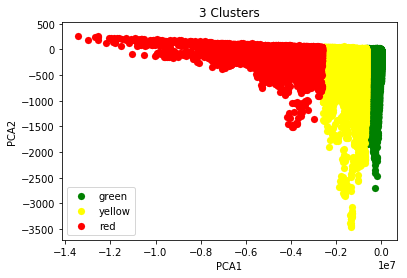

In [6]:
def kmeans(num_clusters):
    k_means_pipe = Pipeline(stages = [ 
    #feature.VectorAssembler(inputCols=["DaysonMarket", "AvgListingPrice"],outputCol="scores")
    feature.VectorAssembler(inputCols=["PriceDecreaseCount", "PriceIncreaseCount", "DaysonMarket", "AvgListingPrice", "NewListingCount", "ActiveListingCount", "TotalListingCount"],outputCol="features"),
    feature.PCA(k=2, inputCol="features", outputCol="scores"),
    clustering.KMeans(k = num_clusters, seed = 2, featuresCol='scores', predictionCol='kmeans_clust')]).fit(df)
    kmeansModel = k_means_pipe.transform(df)
    colmap = {0: 'green', 1: 'yellow', 2: 'red',3: 'purple', 4: 'blue', 5: 'brown',6: 'teal', 7: 'magenta'}
    colors = []
    X = np.array(kmeansModel.select('scores').rdd.map(lambda x: x['scores']).collect())
    for _ in np.array(kmeansModel.select('kmeans_clust').rdd.map(lambda x: x['kmeans_clust']).collect()):
        colors.append(colmap[_])
    fig, ax = plt.subplots()
    #plt.figure(figsize=(30,15))
    for i in range(num_clusters):
        tempX,tempY=[],[]
        for j,_ in enumerate(colors):
            if _==colmap[i]:
                tempX.append(X[j,0])
                tempY.append(X[j,1])
        plt.scatter(tempX, tempY, s=50, label= colmap[i], linewidth=0.1, c= colmap[i])
    plt.title(str(num_clusters)+" Clusters")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.legend()
    plt.savefig("kmeansPca.png")
    return kmeansModel
kmeansModelPCA = kmeans(3)

In [8]:
va_PCA = feature.VectorAssembler(inputCols=["PriceDecreaseCount", "PriceIncreaseCount", "DaysonMarket", "NewListingCount", "ActiveListingCount", "TotalListingCount"],outputCol="features_PCA")
training_df_PCA, testing_df_PCA, validation_df_PCA = va_PCA.transform(kmeansModelPCA).randomSplit([0.6, 0.3, 0.1],seed =1)
rf_PCA = classification.RandomForestClassifier(featuresCol="features_PCA", labelCol='kmeans_clust')
rfModel_PCA = rf_PCA.fit(training_df_PCA)

In [9]:
bce_PCA = evaluation.BinaryClassificationEvaluator(labelCol='kmeans_clust')
print('Training Data Accuracy: ',bce_PCA.evaluate(rfModel_PCA.transform(testing_df_PCA)))

print('Validation Data Accuracy: ',bce_PCA.evaluate(rfModel_PCA.transform(validation_df_PCA)))

Training Data Accuracy:  0.6236908106342774
Validation Data Accuracy:  0.6252114305180106
